In [46]:
%load_ext jupyternotify

import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
from scipy.constants import e, k, h
from scipy.interpolate import interp1d
import itertools
import numba
from numba import jit
from numba.core import types
from numba.typed import Dict
from scipy.optimize import minimize, basinhopping
rok_energy = 1e-3*e
Delta = 0.166*1e-3*e

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [47]:
@jit(nopython=True)
def gamma(g0, v0, T, N):
    numerator = np.exp(v0/(k*T)) + N
    denominator = np.exp(v0/(k*T)) - 1
    return g0*numerator/denominator

@jit(nopython=True)
def etta(g0, v0, T, N):
    numerator = N*gamma(g0, v0, T, N)
    denominator = 4*k*T*((np.cosh(v0/(2*k*T)))**2)
    return numerator/denominator

@jit(nopython=True)
def llambda(v0, T, N):
    numerator = np.exp(v0/(k*T)) + 1
    denominator = np.exp(v0/(k*T)) + N
    return numerator/denominator
    

In [48]:
@jit(nopython=True)
def p0(smg, T, N):
    numerator = np.exp(smg/(k*T))
    denominator = np.exp(smg/(k*T)) + N
    return numerator/denominator

@jit(nopython=True)
def q_capacitance(smg, T, N, dne, dng):
    return (e**2) * (p0(smg, T, N)*(dng - dne) + dne)

@jit(nopython=True)
def tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ng - ne)*gamma(g0, smg, T, N)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

@jit(nopython=True)
def total_capacitance(g0, smg, dsmg, T, N, ne, ng, dne, dng, w):
    return tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w) + q_capacitance(smg, T, N, dne, dng)

@jit(nopython=True)
def I_resistance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ng - ne)*(w**2)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

In [49]:
dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
Uset = tuple(np.sort([float(file_names[2:]) for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

Gamma_dict = tuple([np.array([file_names.split('=')[-1]
                         for file_names in os.listdir(dirpath+f'U={Uvals}')
                         if file_names[0:2]=='U=']) for Uvals in Uset])

@jit(nopython=True)
def Gamma_dict_func(U):
    for idx, Uvals in enumerate(Uset):
        if Uvals==U:
            return Gamma_dict[idx]

In [50]:
optical1_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])

n1_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])

n2_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])


In [51]:
@jit(nopython=True)
def optical_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return optical1_data[Uset.index(U)][idx,:,:]

@jit(nopython=True)
def n1_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return n1_data[Uset.index(U)][idx,:,:]
        
@jit(nopython=True)
def n2_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return n2_data[Uset.index(U)][idx,:,:]
        
@jit(nopython=True)
def rok_data_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return optical1_data[Uset.index(U)][idx,:,:], n1_data[Uset.index(U)][idx,:,:], n2_data[Uset.index(U)][idx,:,:]
        

In [52]:
path = "G:\\My Drive\\GROWTH\\Quantum computing\\Majorana Project\\Experimental data\\data-oct4-21-mail-filip\\data\\"
dset_list2 = np.array(["01","02","03","04","05", "06", "07", "08", "09", "10"])
dataset_data2 = np.array(
    [
        np.loadtxt(
            f"{path}dataset_opening_{dset}.csv",
            skiprows=1,
            delimiter=','
        )[:,[0,1,5]] for dset in dset_list2
    ]
)

In [53]:
@jit(nopython=True)
def dataset_capfunc(dset):
    for idx in range(len(dset_list2)):
        if dset_list2[idx]==dset:
            return dataset_data2[idx,:,0:2]

@jit(nopython=True)
def dataset_resfunc(dset):
    for idx in range(len(dset_list2)):
        if dset_list2[idx]==dset:
            return dataset_data2[idx,:,0:3:2]

In [54]:
@jit(nopython=True)
def expvals(dset,sym):
    rangeval = 0.605
    capset = dataset_capfunc(dset)
    resset = dataset_resfunc(dset)
    exp_caps = capset[:,1]
    exp_ires = 1/resset[:,1]
    vex = capset[:,0]*1e3
    
    filter_arry = (vex<(rangeval))*(-rangeval<vex)
    exp_caps = exp_caps[filter_arry]
    exp_ires = exp_ires[filter_arry]
    vex = vex[filter_arry]
    
    exp_caps = exp_caps*1e15
    exp_ires = np.abs(exp_ires)*1e8
    
    if sym:
        exp_caps = (exp_caps + exp_caps[::-1])/2
        exp_ires = (exp_ires + exp_ires[::-1])/2
    return vex, exp_caps, exp_ires


In [55]:
@jit(nopython=True)
def fitting_s2(gammaa,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    
#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
    op1,n1,_ = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, 0, dn_g)*1e15
    
    return Q_Caps

@jit(nopython=True)
def fitting_s3(gammaa,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    
    return Q_Caps

@jit(nopython=True)
def fitting_s4(gammaa,g0,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    ds_mg = (ds_mg + ds_mg[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    
    return Q_Caps + T_Caps

@jit(nopython=True)
def fitting_s5(gammaa,g0,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    return C_total, Ires

In [56]:
@jit(nopython=True)
def fitting_s6(U,gammaa,g0,alpha,T,N,v0):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    return C_total, Ires

In [60]:
@jit(nopython=True)
def weight_s6(U,dset,gammaa,g0,alpha,T,N,sym):
    expV, expC, expIR = expvals(dset, sym)
    theoC, theoIR = fitting_s6(U,gammaa,g0,alpha,T,N,expV)
    weitC = ((theoC - expC)**2)/(np.maximum(0.027,(theoC + expC)/2)**2)*(1 - np.abs(expV)/0.6)
    weitIR = ((theoIR - expIR)**2)/(np.maximum(1,(theoIR + expIR)/2)**2)*(1 - np.abs(expV)/0.6)
    return np.sum(weitC)+np.sum(weitIR)

@jit(nopython=True)
def total_weight_s6(U,dset,g0,alpha,T,N,sym):
    gset = Gamma_dict_func(U)
    weightset = [weight_s6(U,dset,gama,g0, alpha,T,N,sym) for gama in gset]
    weightset = np.array(weightset)
    winweitidx = np.argmin(weightset)
    return gset[winweitidx], weightset[winweitidx]

@jit(nopython=True)
def total_set_weight_s6(params,sym,U):
    g0fac, alpha,T,fac = params
    dset_list = ["01","02","03","04","05", "06", "07", "08", "09", "10"]
    allweightset = np.array([total_weight_s6(U,dset,10**g0fac,alpha,T/100,10**fac,sym)[1] for dset in dset_list])
    totalweight = np.sum(allweightset)
    return totalweight
    
def fitplot_s6(dset,g0,alpha,T,N,sym,U):
    expV, expC, expIR = expvals(dset,sym)
    
    gamma, weit = total_weight_s6(U,dset,g0,alpha,T,N,sym)
    print(gamma, weit)
    TheoC, TheoIR = fitting_s6(U,gamma,g0,alpha,T,N,expV)
    
    fig, axes = plt.subplots(1,2)
    axes[0].plot(expV, expC)
    axes[0].plot(expV, TheoC)
    axes[1].plot(expV, expIR)
    axes[1].plot(expV, TheoIR)
    print(np.mean(np.abs(TheoIR)))

0.09000 0.8269934441272985
0.11900458118151655


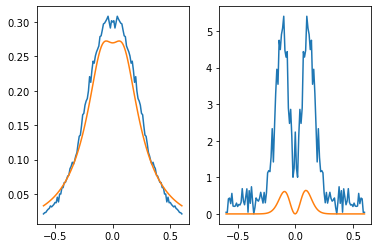

In [19]:
fitplot_s6('09', 10**8.0, 0.65, 10/100, 10**6.5, 1, 0.333)

In [61]:
# %%timeit
total_set_weight_s6((8.0, 0.32, 6.0, 6.0),1,0.333)

858.6231373185626

In [22]:
def minimize_func(U):
    result_s6 = minimize(total_set_weight_s6, (8.0, 0.32, 6.0, 6.0),args=(1,U),method = 'trust-constr')
    return_set = [result_s6.success]
    if result_s6.success:
        return_set.append(result_s6.fun)
        return_set.append(result_s6.x)
    return return_set


In [16]:
# bigres = [minimize_func(Uvals) for Uvals in Uset]
# bigres

[[True,
  547.8799338450174,
  array([9.55896962, 0.32909429, 7.04973209, 8.62891817])],
 [True,
  523.6173413717667,
  array([9.64525686, 0.35893826, 6.72531223, 8.90351363])],
 [True,
  508.3904845831663,
  array([9.78751573, 0.36061751, 6.72216979, 6.93444247])],
 [True,
  432.96220744626237,
  array([8.41777028, 0.45398928, 8.01185677, 4.91367983])],
 [True,
  410.71851664308383,
  array([8.27162439, 0.57850299, 9.7486803 , 3.35282322])],
 [True,
  602.7858582628681,
  array([8.45820124, 0.69714385, 7.25927161, 4.53855368])],
 [True,
  859.8703544256599,
  array([8.94143399, 0.92223335, 5.44149643, 5.03635384])]]

In [17]:
def minimize_funch(U):
    result_sh6 = basinhopping(total_set_weight_s6, (8.0, 0.32, 6.0, 6.0),
                      niter=30, minimizer_kwargs={'args':(1,U),"method": 'trust-constr'})#, T=10, stepsize=2)
    return_set = [result_sh6.lowest_optimization_result.success]
    if result_sh6.lowest_optimization_result.success:
        return_set.append(result_sh6.lowest_optimization_result.fun)
        return_set.append(result_sh6.lowest_optimization_result.x)
    return return_set


In [23]:
Uset

(0.166, 0.249, 0.333, 0.416, 0.5, 0.666, 1.0)

In [24]:
%%time
bigresh = []
for Uvals in [0.333]:
    setss = minimize_funch(Uvals)
    print(setss)
    bigresh.append(setss)
    
# 202111101144 (Only C weight)
# # [True, 38.59061299862114, array([ 1.78899856, -0.54690329,  3.26935053, 17.09357124])]
# # Wall time: 9min 57s
# 202111031712 (asym in exp grid Volt corrected)
# # [True, 538.5586131166997, array([ 9.55115561, -0.34076578,  6.95008876,  9.07865271])]
# # [True, 485.5719642183383, array([ 8.536978  ,  0.48937617,  7.61580561, 10.24017876])]
# # [True, 434.8131800731077, array([8.33227551, 0.56360932, 8.55202237, 8.53666427])]
# # [True, 398.981691654197, array([8.2095219 , 0.60182445, 9.94331527, 5.85784255])]
# # [True, 403.13926338470924, array([ 8.17839907,  0.64999913, 10.86044132,  3.93507548])]
# # [True, 499.9491431279738, array([ 7.91216963,  0.9794536 , 15.12965552,  2.50324673])]
# # [True, 845.2315226654318, array([9.16301977, 0.8319036 , 4.4927203 , 6.08740096])]
# # Wall time: 24min 46s


# 202111031410
# # [True, 539.5470218275129, array([ 9.54631701, -0.33922975,  6.8498518 ,  9.2184396 ])]
# # [True, 487.7793070548892, array([ 8.54586097, -0.45980215,  7.51100956,  9.93219463])]
# # [True, 488.0928782179186, array([ 9.73490118, -0.40678044,  6.38886192,  8.67907323])]
# # [True, 400.8491804590692, array([8.17102044, 0.63953229, 9.90145131, 6.45756771])]
# # [True, 403.60771193798143, array([ 8.17329589, -0.65175937, 10.68949787,  3.99943767])]
# # [True, 501.8466896382276, array([ 7.91263779,  0.97920871, 14.9188667 ,  2.53531255])]
# # [True, 847.2844761153954, array([9.17009312, 0.83099355, 4.48926299, 6.08868889])]



[True, 38.59061299862114, array([ 1.78899856, -0.54690329,  3.26935053, 17.09357124])]
Wall time: 9min 57s


In [29]:
total_set_weight_s6(( 1.78899856, -0.54690329,  3.26935053, 17.09357124),1,0.333)

38.59061299862103

In [32]:
min_idx = np.argmin([bigreshvals[1] for bigreshvals in bigresh])
print('U =',Uset[min_idx])
print('Optvalues :',bigresh[min_idx][2])

U = 0.416
Optvalues : [8.2095219  0.60182445 9.94331527 5.85784255]


In [25]:
def gridplotfit_v3(res_list,sym,U,save=False):
    plt.close()
    g0fac,alpha,T,fac = res_list
    dset_list = dset_list2
    allweightset = [total_weight_s6(U,dset,10**g0fac,alpha,T/100,10**fac,sym)[0] for dset in dset_list]
    scale = 4
    fig, (axes1, axes2, axes3, axes4, axes5, axes6) = plt.subplots(6,9,figsize=(9.5*scale,6*scale))

    for gamma, dset,axis1,axis2,axis3,axis4,axis5,axis6 in zip(allweightset,dset_list,axes1,axes2,axes3,axes4,axes5,axes6):
        expV, expC, expIR = expvals(dset, sym)
        theoC, theoIR = fitting_s6(U,gamma,10**g0fac,alpha,T/100,10**fac,expV)

        axis1.plot(expV, expC,label=f'data set = {dset}')
        axis1.plot(expV, theoC,label=f'$\Gamma_t = ${gamma}')
        axis1.legend()
        axis1.set_ylim(0.0,None)
        
        axis2.plot(expV, expIR,label=f'data set = {dset}')
        axis2.plot(expV, theoIR,label=f'$\Gamma_t = ${gamma}')
        axis2.legend()
#         axis1.set_ylim(0.0,None)
        
        v0 = expV*alpha
        nu = (1 - (v0/U))
        op1 = optical_func(U,gamma)
        s_mg = np.interp(nu, op1[:,0], op1[:,1])
        axis3.plot(expV, s_mg,label=f'$\Gamma_t = ${gamma}')
#         axis2.legend()
        axis3.set_ylim(0.0,2.05)
        
        n1 = n1_func(U,gamma)
        n2 = n2_func(U,gamma)
        n_g = np.interp(nu, n1[:,0], n1[:,1])
        n_e = np.interp(nu, n2[:,0], n2[:,1])

        axis4.plot(expV, n_g,label=f'$n_g$')
        axis4.plot(expV, n_e,label=f'$n_e$')
        axis4.legend()
        axis4.set_ylim(0.0,2.1)
        
        C_tot, _ = fitting_s6(U,gamma,10**g0fac,alpha,T/100,10**fac,expV)
        C_qn = fitting_s3(gamma,alpha,T/100,10**fac,expV,U=U)
        C_q0 = fitting_s2(gamma,alpha,T/100,10**fac,expV,U=U)
        
        P0g = p0(s_mg*Delta, T/100, 10**fac)
        axis5.plot(expV,P0g,label=f'$\Gamma_t = ${gamma}')
        axis5.legend()
        
        axis6.plot(expV,C_tot,'k',label=r'$C_{total}$')
        axis6.plot(expV,C_q0,'--',label=r'$C_{q,g}$')
        axis6.plot(expV,C_qn - C_q0,'--',label=r'$C_{q,e}$')
        axis6.plot(expV,C_tot - C_qn,'--',label=r'$C_t$')
        axis6.legend()
        axis6.set_ylim(0.0,None)

    axes1[0].set_ylabel(r'Capacitance, C (fF)',fontsize=15)
    axes2[0].set_ylabel(r'Conductance, S ($10^{-8} \Omega^{-1}$)',fontsize=15)
    axes3[0].set_ylabel(r'Shiba mini-gap, $\delta / \Delta $',fontsize=15)
    axes4[0].set_ylabel(r'Occupation, $n$',fontsize=15)
    axes5[0].set_ylabel(r'P_{g,0}',fontsize=15)
    axes6[0].set_ylabel('Capacitance, C (fF)',fontsize=15)
    
    axes6[4].set_xlabel(r'$V_{P0} (mV) $',fontsize=20)
    
                   
    parameter_string = f"$T = {T*10:.3f} mK $\
            $log_{{10}} \\Gamma^0 = {g0fac:.3f}$\
            $\\alpha        = {alpha:.3f} $\
            $U       = {U:.3f} $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    if sym:
        fig.text(
        0.5, 0.902, f"Stage 6 (Symmetrized) TW = {total_set_weight_s6(res_list,sym,U):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)

    if save:
        if sym:
            plt.savefig(f"2D_grid_sym_S6_U{U}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['log10_Go-','alpha-','10mK_T-','log10_N-'],res_list)]}.pdf", format='pdf')
        else:
            plt.savefig(f"2D grid Not-sym S6 {[f'{member[0]}{member[1]:.2f}' for member in zip(['g0','a','T','N'],res_list)]}.pdf", format='pdf')
      

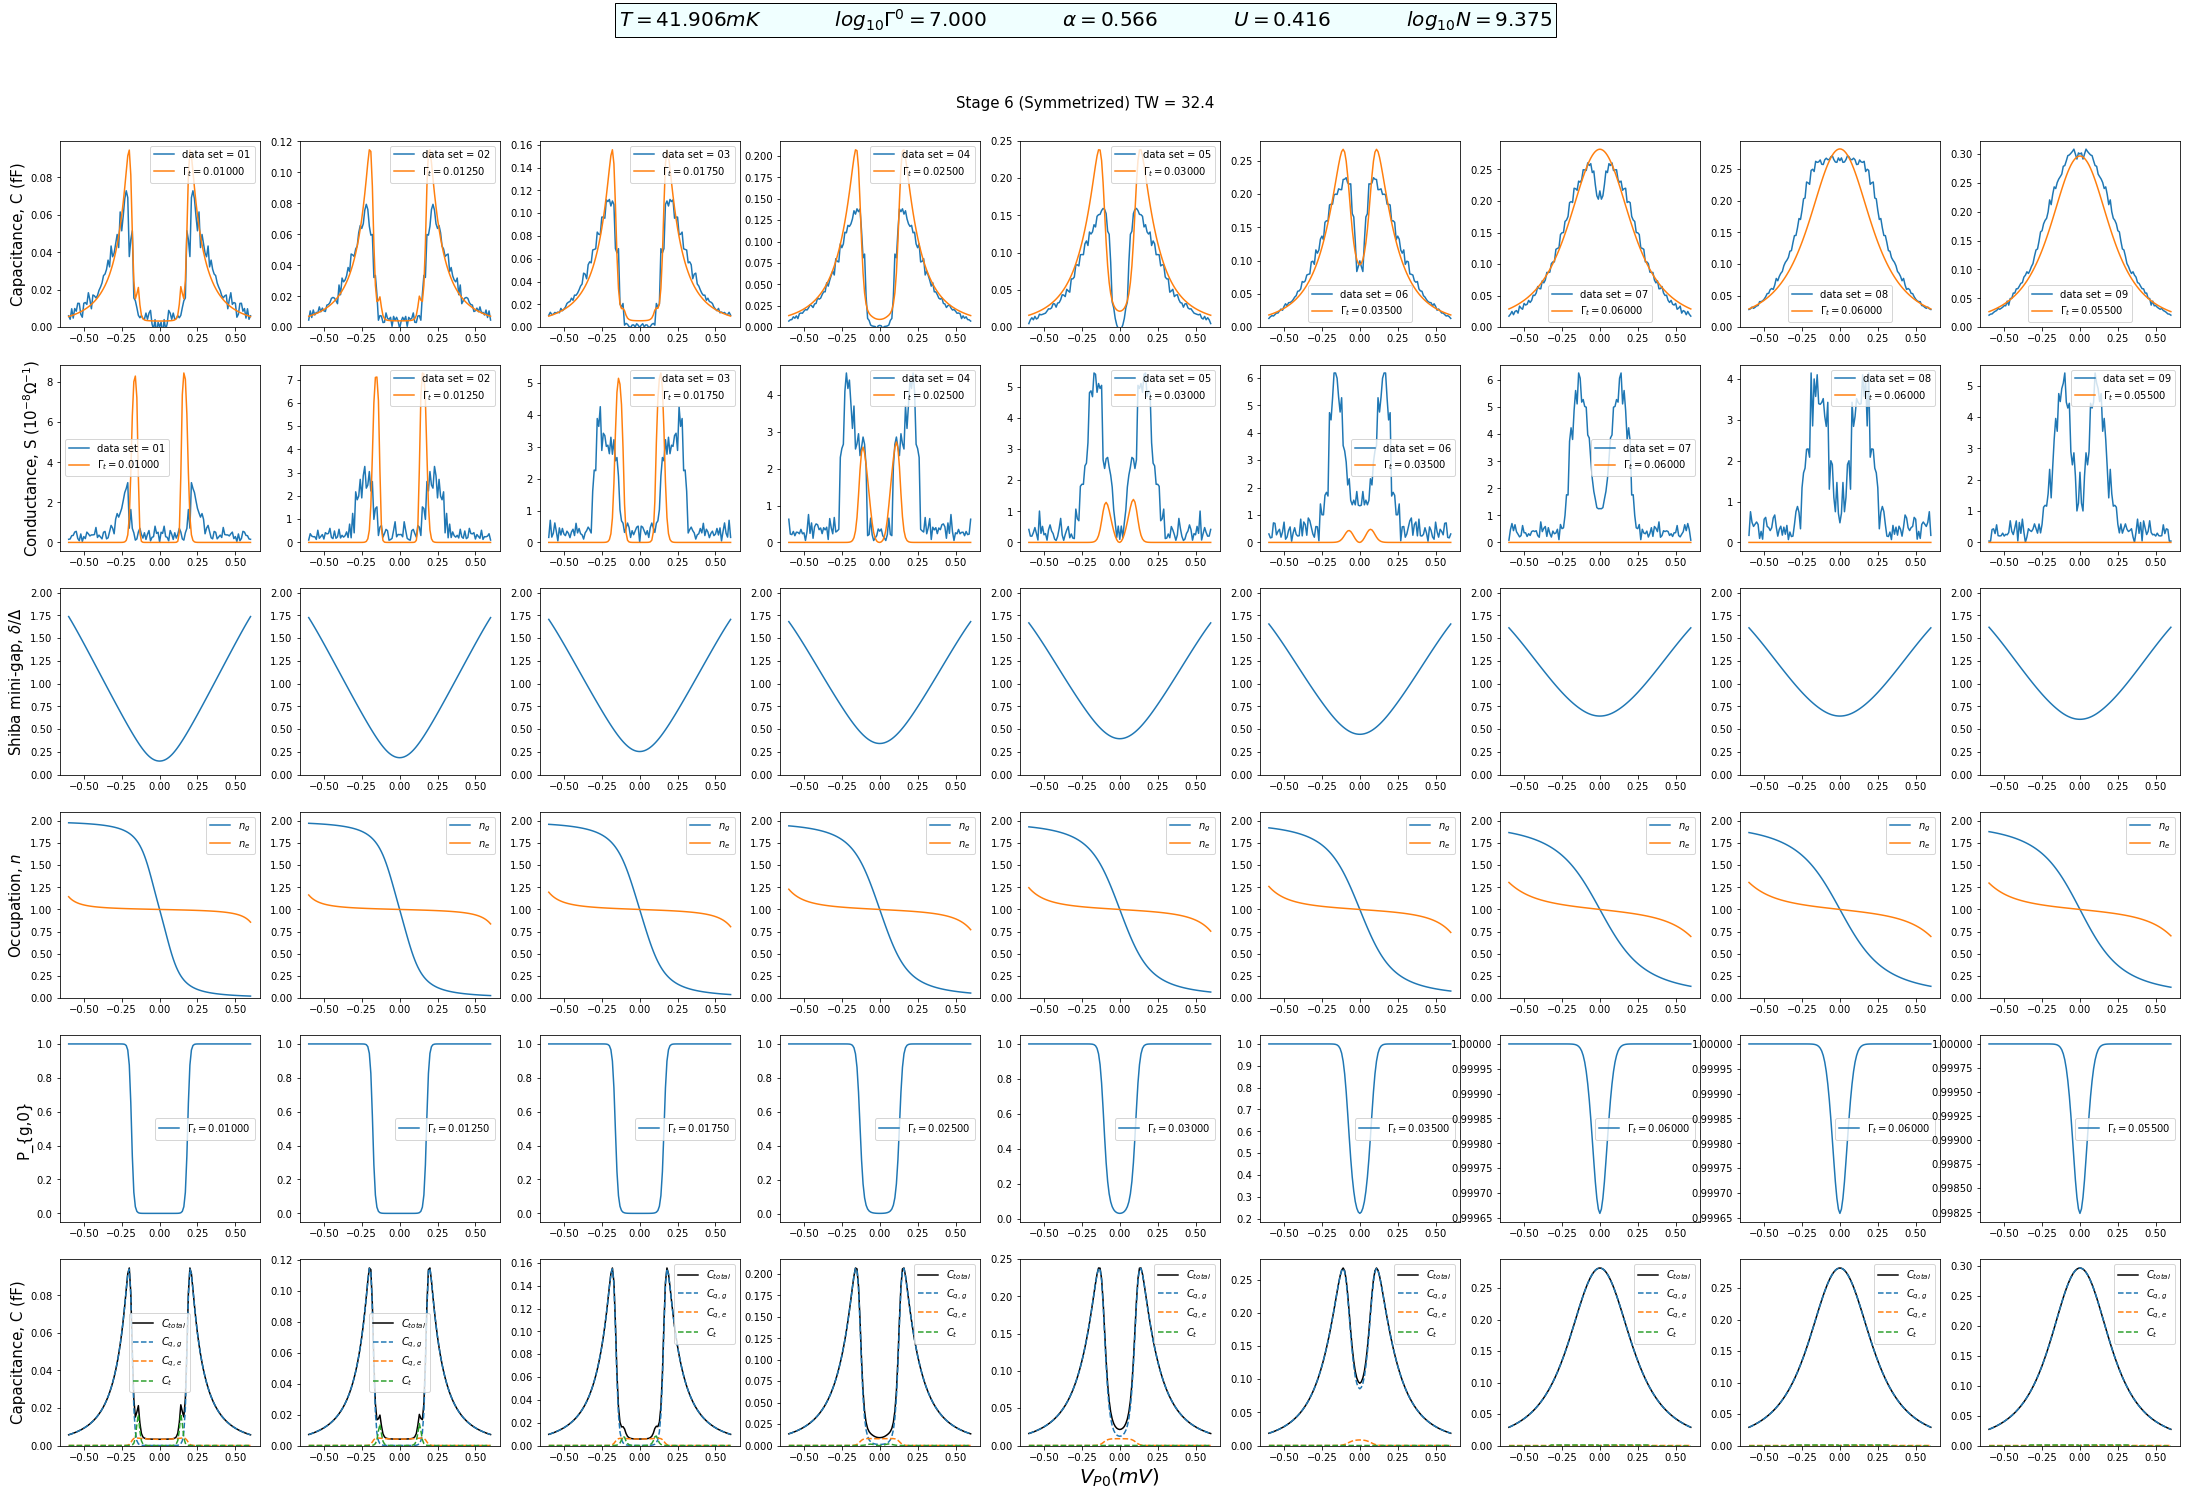

In [45]:
# gridplotfit_v3(bigresh[min_idx][2],1,Uset[min_idx],False)
# 5.22122749, 0.56594147, 4.19060733, 9.37497055
gridplotfit_v3((7.0, 0.56594147, 4.19060733, 9.37497055),1,0.416,True)

In [ ]:
# # RENAME CODE

# For U Dirs
# # # for file_names in os.listdir(dirpath):
# # #     if file_names[0:2]=='U=':
# # #         os.rename(dirpath+file_names,dirpath+f'{file_names[:4]}{int(file_names[4:]):<03d}')

# For Gt dirs
# # # dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
# # # Uset = tuple(np.sort([file_names[2:] for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

# # # Gamma_dict = list([list([file_names.split('=')[-1]
# # #                          for file_names in os.listdir(dirpath+f'U={Uvals}')
# # #                          if file_names[0:2]=='U=']) for Uvals in Uset])
# # # for idx1, usets in enumerate(Gamma_dict):
# # #     for idx2, gammavals in enumerate(usets):
# # #         filepath = f"U={Uset[idx1]}\\U={Uset[idx1]}_Gamma="
# # #         oldpath = dirpath+filepath+gammavals
# # #         newpath = dirpath+filepath + f'{gammavals[:-1]}{int(gammavals[-1]):<010d}'[:7]
# # #         os.rename(oldpath,newpath)


In [ ]:
# dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
# # Uset = list(np.sort([file_names[2:] for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

# # Gamma_dict = {} #Dict.empty(key_type = types.unicode_type, value_type = types.float64[:])
# optical1_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])
# # n1_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])
# # n2_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])

# # for Uvals in Uset:
# #     Gamma_dict(Uvals) = np.array([file_names.split('=')[-1]
# #                          for file_names in os.listdir(dirpath+f'U={Uvals}')
# #                          if file_names[0:2]=='U='])
    
# # Gamma_dict['1.0'].remove('0.005') # this data file is incomplete

# for Uvals in Uset:
#     optical1_data[Uvals] = np.array(
#         [
#             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
#             for gammaa in Gamma_dict_func(Uvals)
#         ]
#     )
# #     n1_data[Uvals] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict[Uvals]
# #         ]
# #     )
# #     n2_data[Uvals] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict[Uvals]
# #         ]
# #     )

# # n1_data       = {Uvals:np.array([np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400] 
# #                                  for gammaa in Gamma_dict[Uvals]]) 
# #                  for Uvals in Uset}
# # n2_data       = {Uvals:np.array([np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400] 
# #                                  for gammaa in Gamma_dict[Uvals]]) 
# #                  for Uvals in Uset}

In [ ]:
# 
# # Udtype = np.dtype([(f'U{Uvals}', np.float64, (len(Gamma_dict_func(Uvals)),400)) for Uvals in Uset])
# # optical1_data = np.zeros(2,dtype=Udtype)
# # n1_data = np.zeros(2,dtype=Udtype)
# # n2_data = np.zeros(2,dtype=Udtype)

# # for Uvals in Uset:
# #     optical1_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     optical1_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]
    
# #     n1_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     n1_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]
    
# #     n2_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     n2_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]